This notebools is based on the following paper:

>**The tricellular vertex-specific adhesion molecule Sidekick facilitates polarised cell intercalation during Drosophila axis extension** _Tara M Finegan, Nathan Hervieux, Alexander Nestor-Bergmann, Alexander G. Fletcher, Guy B Blanchard, Benedicte Sanson_ bioRxiv 704932; doi: https://doi.org/10.1101/704932 

In particular, the authors expose a nice way to account for rosettes and solve topology changes in a more generic and I think robust way than T1 transition. I think, it allows vertices with more than 3 out-edges to have a finite lifetime, and avoids T1 oscillations


I explore its implementation in [tyssue](https://github.com/damcb/tyssue), in 2D (also maybe in 3D, though it's less clear how :p).

In [1]:
# % conda install -c conda-forge tyssue

In [1]:
import numpy as np
import pandas as pd
import ipyvolume as ipv

import matplotlib.pylab as plt
%matplotlib inline


from tyssue import config
from tyssue import Monolayer, Sheet
from tyssue import PlanarGeometry as geom
from tyssue.generation import extrude
from tyssue.dynamics import model_factory, effectors
from tyssue.solvers.quasistatic import QSSolver

from tyssue.topology import remove_face, close_face
from tyssue.draw import sheet_view, highlight_cells

from tyssue.core.sheet import get_opposite

from tyssue.generation import single_cell
from tyssue.core.objects import _is_closed_cell
from tyssue.topology import condition_4i, condition_4ii

### Create a small patch of cells in 2D and a simple mechanical model

In [4]:
sheet = Sheet.planar_sheet_2d('flat', 30, 30, 1, 1, noise=0.2)
to_cut = sheet.cut_out([(0.1, 6), (0.1, 6)])
sheet.remove(to_cut, trim_borders=True)
sheet.sanitize(trim_borders=True)
geom.center(sheet)
geom.update_all(sheet)
model = model_factory(
    [
        effectors.LineTension,
        effectors.FaceContractility,
        effectors.FaceAreaElasticity
    ]
)

specs = {
    "face": {
        "contractility": 5e-2,
        "prefered_area": sheet.face_df.area.mean(),
        "area_elasticity": 1.
    },
    "edge": {
        "line_tension": 1e-2,
        "is_active": 1
    },
    "vert": {
        "is_active": 1
    },
}

sheet.update_specs(specs, reset=True)

Reseting column is_active of the vert dataset with new specs


### Gradient descent

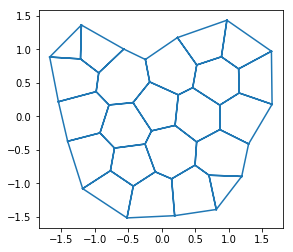

In [5]:
solver = QSSolver()

res = solver.find_energy_min(sheet, geom, model)

fig, ax = sheet_view(sheet, mode="quick")


## Formation of rosettes

<hr/>

![first screencap, forming rosettes](../data/png/finegan_etal_screencap1.png)

_Finegan et al. 2019_

In [6]:
# first let's get vertex ranks
# Note that this is 2 for border edges, might cause problems...
sheet.vert_df['rank'] = sheet.edge_df.groupby('srce').size()

### Merge vertices

In [12]:
def merge_vertices(sheet, edge):
    srce, trgt = sheet.edge_df.loc[edge, ['srce', 'trgt']]
    sheet.vert_df.loc[srce, sheet.coords] = sheet.vert_df.loc[
        [srce, trgt], sheet.coords].mean(axis=0)
    sheet.vert_df.drop(trgt, axis=0, inplace=True)
    # rewire
    sheet.edge_df.replace({"srce": trgt, "trgt": trgt}, srce, inplace=True)
    # all the edges parallel to the original
    collapsed = sheet.edge_df.query("srce == trgt")
    sheet.edge_df.drop(collapsed.index, axis=0, inplace=True)
    sheet.reset_index()
    sheet.reset_topo()
    sheet.vert_df['rank'] = sheet.edge_df.groupby('srce').size()

    

Maximum vertex rank:  4


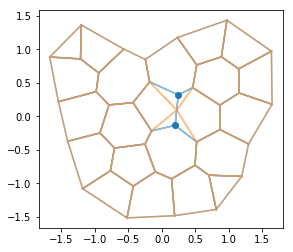

In [8]:
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})
center_edge = sheet.edge_df.eval("sx**2 + sy**2").idxmin()
ax.scatter(sheet.edge_df.loc[center_edge, ["sx", "tx"]],
           sheet.edge_df.loc[center_edge, ["sy", "ty"]])

merge_vertices(sheet, center_edge)
geom.update_all(sheet)
fig, ax = sheet_view(sheet, mode="quick", ax=ax, edge={"alpha": 0.5})

print("Maximum vertex rank: ", sheet.vert_df['rank'].max())

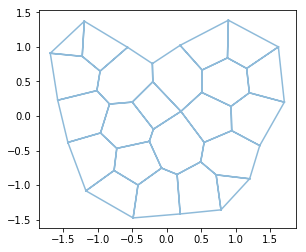

In [9]:
res = solver.find_energy_min(sheet, geom, model)
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})


### Do it again to increase rank

Maximum vertex rank:  6


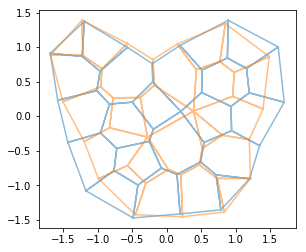

In [10]:
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

for i in range(4):
    center_edge = sheet.edge_df.eval("sx**2 + sy**2").idxmin()
    merge_vertices(sheet, center_edge)
    geom.update_all(sheet)
    res = solver.find_energy_min(sheet, geom, model)
    
fig, ax = sheet_view(sheet, mode="quick", ax=ax, edge={"alpha": 0.5})


print("Maximum vertex rank: ", sheet.vert_df['rank'].max())

## Rosettes resolution

<hr/>

![Second screencap, solving rosettes](../data/png/finegan_etal_screencap2.png)

_Finegan et al. 2019_



As far as I understand, the difference between rank 5+ and rank 4 is not topological, but geometrical (the "old" vertex is moved towards the opposite cell center) and statistical because $p_4$ is higher than $p_{5+}$

In [11]:



def split_vert(sheet, vert, epsilon=0.1):
    
    out_edges = sheet.edge_df.query(f"srce == {vert}")
    edge = np.random.choice(out_edges.index)
    face = out_edges.loc[edge, 'face']
    face_edges = sheet.edge_df.query(f"face == {face}")
    prev_v, = face_edges[face_edges["trgt"] == vert]["srce"]
    next_v, = face_edges[face_edges["srce"] == vert]["trgt"]

    # Add a vertex
    sheet.vert_df = sheet.vert_df.append(
        sheet.vert_df.loc[vert], ignore_index=True)
    new_vert = sheet.vert_df.index[-1]
    
    # Move it towards the face center
    r_ia = (sheet.face_df.loc[face, sheet.coords] - sheet.vert_df.loc[vert, sheet.coords])
    sheet.vert_df.loc[new_vert, sheet.coords] += r_ia * epsilon / np.linalg.norm(r_ia)
    
    # rewire
    connected = sheet.edge_df[
        sheet.edge_df[["srce", "trgt"]]
        .isin([prev_v, next_v])
        .sum(axis=1)
        .astype(bool)
    ]
    
    sheet.edge_df.loc[connected.index] = connected.replace(
        {"srce": vert, "trgt": vert}, new_vert
    )
    for face in connected["face"]:
        close_face(sheet, face)

    sheet.reset_index()
    sheet.reset_topo()
    sheet.vert_df['rank'] = sheet.edge_df.groupby('srce').size()


### Solve for a single edge

Maximum vertex rank prior to rearangement:  6
Maximum vertex rank:  5


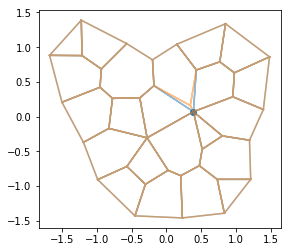

In [12]:
#sheet = bck.copy()
max_rank = sheet.vert_df['rank'].idxmax()

print("Maximum vertex rank prior to rearangement: ", sheet.vert_df['rank'].max())


fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})
max_rank_vert = sheet.vert_df['rank'].idxmax()

ax.scatter(sheet.vert_df.loc[max_rank_vert, "x"],
           sheet.vert_df.loc[max_rank_vert, "y"])

split_vert(sheet, max_rank_vert)
geom.update_all(sheet)
fig, ax = sheet_view(sheet, mode="quick", ax=ax, edge={"alpha": 0.5})

print("Maximum vertex rank: ", sheet.vert_df['rank'].max())


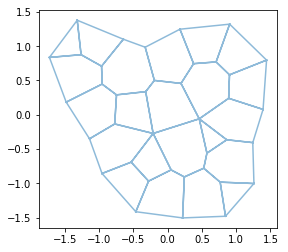

In [13]:
res = solver.find_energy_min(sheet, geom, model)
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

### Solve repeatedly

Maximum vertex rank prior to rearangement:  5
Maximum vertex rank:  5
Maximum vertex rank:  4
Maximum vertex rank:  4
Maximum vertex rank:  3


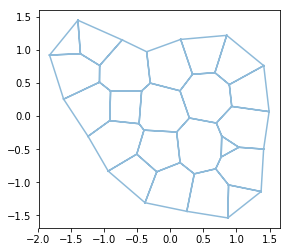

In [14]:
#sheet = bck.copy()
max_rank = sheet.vert_df['rank'].max()
print("Maximum vertex rank prior to rearangement: ", max_rank)

while max_rank > 3:
    max_rank_vert = sheet.vert_df['rank'].idxmax()

    split_vert(sheet, max_rank_vert)
    geom.update_all(sheet)

    res = solver.find_energy_min(sheet, geom, model)
    max_rank = sheet.vert_df['rank'].max()

    print("Maximum vertex rank: ", max_rank)

fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

In [15]:
res = solver.find_energy_min(sheet, geom, model)

In [16]:
sheet.validate()

True

### How about in 3D?



In [40]:
from tyssue import MonolayerGeometry as geom

specs = config.geometry.bulk_spec()

sheet = Sheet.planar_sheet_3d('flat', 8, 9, 1, 1, noise=0.1)
to_cut = sheet.cut_out([(-10, 20), (-10, 20), (-10, 10)])
sheet.remove(to_cut, trim_borders=True)
sheet.sanitize(trim_borders=True)


datasets = extrude(sheet.datasets, method='translation')
eptm = Monolayer('mono', datasets, specs)

geom.center(eptm)
geom.update_all(eptm) 



In [41]:
print(eptm.validate())
c4i, c4ii = condition_4i(eptm), condition_4ii(eptm)
set(c4ii.ravel())

True


set()

In [42]:
model = model_factory([
    effectors.CellVolumeElasticity,
    effectors.FaceContractility,
    #effectors.SurfaceTension,
    effectors.LineTension,
    #effectors.CellAreaElasticity
])

## Initial model settings
dyn_specs = {
    "settings": {
        "threshold_length": 1e-3,
    },
    "cell": {
        "prefered_vol": eptm.cell_df.vol.mean(),
        "prefered_area": eptm.cell_df.area.mean(),
        "vol_elasticity": 14.0,
        #"area_elasticity": 1.0,
    },
    "face": {
        #"surface_tension": 1.0,
        "contractility": 1e-2
    },
    "edge": {
        "line_tension": 0.01,
        "ux": 0.0,
        "uy": 0.0,
        "uz": 0.0,
    }
}

## Those settings are set homogenously in the epithelium
eptm.update_specs(dyn_specs, reset=True)
eptm.face_df.loc[eptm.lateral_faces, 'contractility'] /= 2

solver = QSSolver(with_t1=False, with_t3=False)
res = solver.find_energy_min(eptm, geom, model)
eptm.vert_df['rank'] = eptm.edge_df.groupby('srce').size()

ipv.clear()
eptm.face_df["visible"] =True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)


ipv.show()

Reseting column ux of the edge dataset with new specs
Reseting column uy of the edge dataset with new specs
Reseting column uz of the edge dataset with new specs


In [43]:
eptm.vert_df['rank'].max()

9

In [44]:
eptm.validate()

True

In [45]:

center_edge = eptm.edge_df.query('segment == "apical"').eval("sx**2 + sy**2").idxmin()
merge_vertices(eptm, center_edge)
geom.update_all(eptm)


print("Maximum vertex rank: ", eptm.vert_df['rank'].max())

ipv.clear()
eptm.face_df["visible"] = eptm.face_df['segment'] == "lateral"
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)


ipv.show()

Maximum vertex rank:  14


In [46]:
print(eptm.validate())
c4i, c4ii = condition_4i(eptm), condition_4ii(eptm)
set(c4ii.ravel())

True


set()

In [47]:
eptm.vert_df['rank'].idxmax()

97

In [48]:
bck = eptm.copy()


In [49]:


sing_cell = single_cell(eptm, 46)
sing_cell.edge_df.drop(sing_cell.edge_df.query('face == 0').index, axis=0, inplace=True)
sing_cell.face_df.drop(0, axis=0, inplace=True)
sing_cell.reset_index()
sing_cell.reset_topo()
print(sing_cell.Nf)



6


In [50]:
def close_cell(eptm, cell):
    eptm.face_df = eptm.face_df.append(
        eptm.face_df.iloc[0], ignore_index=True)

    new_face = eptm.face_df.index[-1]
    
    face_edges = eptm.edge_df[eptm.edge_df["cell"] == cell]
    oppo = get_opposite(face_edges)
    new_edges = face_edges[oppo == -1].copy()
    if not new_edges.shape[0]:
        return 0
    print("closing cell", cell)
    new_edges[["srce", "trgt"]] = new_edges[["trgt", "srce"]]
    new_edges['face'] = new_face
    new_edges.index = new_edges.index + sing_cell.edge_df.index.max()
    eptm.edge_df = eptm.edge_df.append(new_edges, ignore_index=False)

    eptm.reset_index()
    eptm.reset_topo()
    return 0
    

def split_vert_bulk(eptm, vert, epsilon=0.1, edge=None):
    
    all_edges = eptm.edge_df[
        (eptm.edge_df["trgt"] == vert)
        | (eptm.edge_df["srce"] == vert)
    ]

    # choose a terahedron
    if edge is None:
        edge = np.random.choice(all_edges.index)
    cell = eptm.edge_df.loc[edge, "cell"]
    face = eptm.edge_df.loc[edge, "face"]
    
    # Get all the edges bordering this terahedron
    cell_eges = eptm.edge_df.query(f'cell == {cell}')
    prev_vs = cell_eges[cell_eges["trgt"] == vert]["srce"]
    next_vs = cell_eges[cell_eges["srce"] == vert]["trgt"]

    connected = all_edges[
        all_edges["trgt"].isin(next_vs)
        | all_edges["srce"].isin(prev_vs)
        | all_edges["srce"].isin(next_vs)
        | all_edges["trgt"].isin(prev_vs)
    ]

    # Add a vertex
    eptm.vert_df = eptm.vert_df.append(
        eptm.vert_df.loc[vert], ignore_index=True)
    new_vert = eptm.vert_df.index[-1]

    # Move it towards the face center
    r_ia = (eptm.face_df.loc[face, eptm.coords] - eptm.vert_df.loc[vert, eptm.coords])
    eptm.vert_df.loc[new_vert, eptm.coords] += r_ia * epsilon / np.linalg.norm(r_ia)

    # Rewire all the border edges to the new vertex
    eptm.edge_df.loc[connected.index] = connected.replace(
        {"srce": vert, "trgt": vert}, new_vert
    )

    # Tidy up
    for face in all_edges["face"].unique():
        close_face(eptm, face)

    for cell in all_edges["cell"]:
        close_cell(eptm, face)
    eptm.reset_index()
    eptm.reset_topo()
    eptm.vert_df['rank'] = eptm.edge_df.groupby('srce').size()



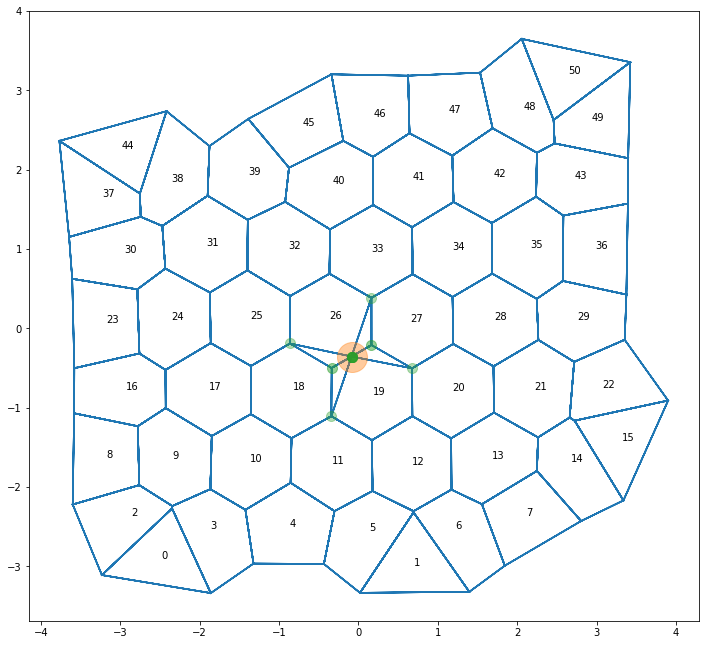

In [138]:
eptm = bck.copy()
vert = eptm.edge_df.query('segment == "apical"').groupby('srce').size().idxmax()

all_edges = eptm.edge_df[
    (eptm.edge_df["trgt"] == vert)
    | (eptm.edge_df["srce"] == vert)
]

fig, ax = sheet_view(eptm, coords = ['x', 'y'], mode="quick")
for cell, (x, y) in eptm.cell_df[['x', 'y']].iterrows():
    ax.text(x, y, str(cell))

    
ax.plot(eptm.vert_df.loc[vert, 'x'], eptm.vert_df.loc[vert, 'y'], 'o', alpha=0.4, ms=30)
ax.plot(all_edges['sx'], all_edges['sy'], 'o', alpha=0.2, ms=10)
fig.set_size_inches(12, 12)

In [52]:
from tyssue.utils import get_sub_eptm

In [53]:
from tyssue.config import draw

In [54]:
def draw_sub(eptm):
    sub = get_sub_eptm(eptm, eptm.edge_df.query("(cx**2 + cy**2) < 1").index)
    sub.reset_index()
    sub.reset_topo()
    geom.update_all(sub)
    draw_spec = {
        "face":{
            "visible": True,
            "alpha": 0.3,
            "color": np.random.rand(sub.Nf),
        },
        "edge": {
            "head_width": 0.0,
        },
        "vert": {"visible":False}
    }

    fig, (xy, zy) = plt.subplots(1, 2, sharex=True)

    fig, xy = sheet_view(sub, mode="2D", ax=xy, **draw_spec)
    fig, zy = sheet_view(sub, mode="2D", coords=["z", "y"], ax=zy, **draw_spec)
    fig.set_size_inches(12, 12)
    return fig, (xy, zy)

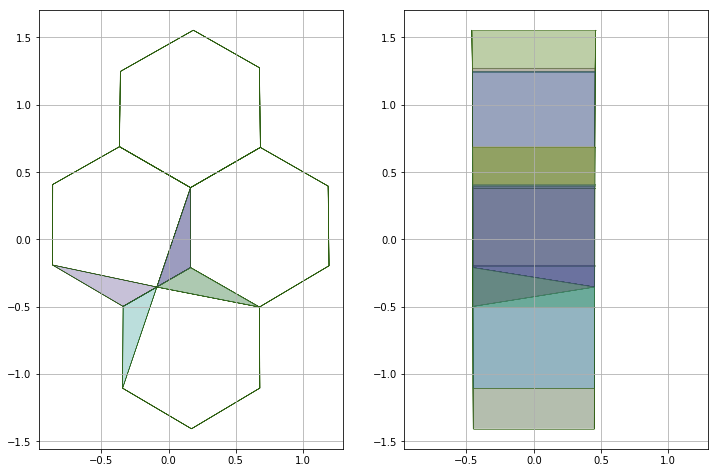

In [122]:
_ = draw_sub(eptm)

In [133]:
faces_edges.shape

(60, 32)

In [131]:
all_edges.shape

(28, 32)

In [267]:
faces = all_edges.groupby('face').apply(
    lambda df: pd.Series(
        {"verts": frozenset(df[['srce', 'trgt']].values.ravel()),
         "cell": df['cell'].iloc[0]}))

cells = all_edges.groupby('cell').apply(
    lambda df: pd.Series(
        {"verts": frozenset(df[['srce', 'trgt']].values.ravel()),
         "faces": frozenset(df['face']),
         "size": df.shape[0]//2,}
    ))


In [269]:
faces

,verts,cell
face,,
18,"(96, 97, 49)",18
19,"(96, 97, 98)",19
26,"(49, 50, 97)",26
27,"(97, 98, 50)",27
340,"(97, 195, 197)",26
341,"(97, 195, 197)",19
342,"(96, 97, 195)",19
343,"(96, 97, 195)",18
344,"(97, 98, 197)",27


In [270]:
cells

,verts,faces,size
cell,,,
18,"(96, 97, 195, 49)","(18, 355, 343)",3
19,"(96, 97, 98, 195, 197)","(345, 19, 341, 342)",4
26,"(97, 195, 197, 49, 50)","(26, 340, 357, 354)",4
27,"(97, 98, 50, 197)","(344, 27, 356)",3


In [277]:
face_pairs = faces.groupby('verts').apply(
    lambda df: df.index.values)

In [278]:
face_pairs

verts
(96, 97, 49)            [18]
(96, 97, 98)            [19]
(49, 50, 97)            [26]
(97, 98, 50)            [27]
(97, 195, 197)    [340, 341]
(96, 97, 195)     [342, 343]
(97, 98, 197)     [344, 345]
(97, 195, 49)     [354, 355]
(97, 50, 197)     [356, 357]
dtype: object

In [265]:
face = 26
cell = faces.loc[face, "cell"]

In [273]:
cells.loc[cell, "size"]

4

In [168]:
from tyssue.core.objects import get_opposite_faces

In [ ]:
get_opposite_faces()

In [279]:
eptms = {}
for face, edge in all_edges.reset_index().groupby("face").first()['edge'].items():
    eptm = bck.copy()
    cell = eptm.edge_df.loc[edge, "cell"]
    print(f"splitting vertex {vert} towards cell {cell} over face {face}")
    split_vert_bulk(eptm, vert, epsilon=0.3, edge=edge)
    c4i, c4ii = condition_4i(eptm), condition_4ii(eptm)
    if len(c4ii):
        
        c4ii_verts = eptm.edge_df[eptm.edge_df['face'].isin(c4ii.ravel())].groupby("face").apply(
            lambda df: set(df['srce']))
        common = c4ii_verts.iloc[0]
        for verts in c4ii_verts:
            common.intersection_update(verts)

        print(eptm.vert_df.loc[common, 'rank'])
    
    ##print("Number of condition 4i faces : ", len(c4i))
    #fig, (xy, zy) = draw_sub(eptm)
    #zy.set_title(f"Number of condition 4ii faces : {len(c4ii)}")
    eptms[face] = eptm
#    if len(c4ii):
#        break
#else:
#    print("All went well :)")

splitting vertex 97 towards cell 18 over face 18
splitting vertex 97 towards cell 19 over face 19
vert
97      7
199    13
Name: rank, dtype: int64
splitting vertex 97 towards cell 26 over face 26
vert
97      7
199    13
Name: rank, dtype: int64
splitting vertex 97 towards cell 27 over face 27
splitting vertex 97 towards cell 26 over face 340
vert
97      7
199    13
Name: rank, dtype: int64
splitting vertex 97 towards cell 19 over face 341
vert
97      7
199    13
Name: rank, dtype: int64
splitting vertex 97 towards cell 19 over face 342
vert
97      7
199    13
Name: rank, dtype: int64
splitting vertex 97 towards cell 18 over face 343
splitting vertex 97 towards cell 27 over face 344
splitting vertex 97 towards cell 19 over face 345
vert
97      7
199    13
Name: rank, dtype: int64
splitting vertex 97 towards cell 26 over face 354
vert
97      7
199    13
Name: rank, dtype: int64
splitting vertex 97 towards cell 18 over face 355
splitting vertex 97 towards cell 27 over face 356
spli

In [80]:
#eptm = eptms[346]
geom.update_all(eptm)
#res = solver.find_energy_min(eptm, geom, model)

In [130]:
ipv.clear()
eptm.face_df["visible"] = False
eptm.face_df["visible"] = eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False

#eptm.face_df.loc[set(condition_4ii(eptm).ravel()), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

In [82]:
all_edges['face'].shape

(28,)

In [83]:
bck_2 = eptm.copy()

In [100]:
new = 199
old = 97

all_edges = eptm.edge_df[
    (
        (eptm.edge_df["srce"] == new)
        & (eptm.edge_df["trgt"] != old)
    )
    | (
        (eptm.edge_df["trgt"] == new)
         & (eptm.edge_df["srce"] != old)
    )
]


for face, edge in all_edges.reset_index().groupby("face").first()['edge'].items():
    eptm = bck_2.copy()
    if not(eptm.vert_df.loc[eptm.edge_df.loc[edge, 'trgt'], 'segment'] == "basal"):
        continue
        
    cell = eptm.edge_df.loc[edge, "cell"]
    print(f"splitting vertex {vert} towards cell {cell} over face {face}")
    split_vert_bulk(eptm, vert, epsilon=0.3, edge=edge)
    c4i, c4ii = condition_4i(eptm), condition_4ii(eptm)
    if len(c4ii):
        
        c4ii_verts = eptm.edge_df[eptm.edge_df['face'].isin(c4ii.ravel())].groupby("face").apply(
            lambda df: set(df['srce']))
        common = c4ii_verts.iloc[0]
        for verts in c4ii_verts:
            common.intersection_update(verts)

        print(eptm.vert_df.loc[common, 'rank'])
        if len(common) == 2:
            break
    ##print("Number of condition 4i faces : ", len(c4i))
    #fig, (xy, zy) = draw_sub(eptm)
    #zy.set_title(f"Number of condition 4ii faces : {len(c4ii)}")
    eptms[face] = eptm


splitting vertex 97 towards cell 26 over face 340
vert
97      7
199    13
Name: rank, dtype: int64


In [108]:
res = solver.find_energy_min(eptm, geom, model)

geom.update_all(eptm)
ipv.clear()
# eptm.face_df["visible"] = eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.6')
eptm.face_df["visible"] = False

eptm.face_df.loc[set(condition_4ii(eptm).ravel()), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": False,
        "color": eptm.face_df.area
    }
)

ipv.show()

In [91]:
eptm.validate()

True